# Validating Sentiwordnet with stopword cleaning
since this had the best overall performance on test and train-data

In [1]:
import pandas as pd # for data processing
import matplotlib.pyplot as plt # to create stat and visualize data
import matplotlib as mpl # to visualize data
import seaborn as sns # to visualize data
from sklearn.metrics import * # calculation of metrics for validation purposes 
import re #regular expressions
import nltk # importing nltk
from nltk.corpus import stopwords
from string import punctuation 
from nltk.corpus import sentiwordnet as swn

setting to show full text content

In [2]:
pd.set_option('display.max_colwidth', None)

## Loading data

In [3]:
df_sentiwordnet_without_stopwords = pd.read_csv('../../Data-Preparation/twitter-corpus/full_corpus_preprocessed.csv')

In [4]:
df_sentiwordnet_without_stopwords['Ground_Truth_Label'].value_counts()

Ground_Truth_Label
positive    519
negative    519
Name: count, dtype: int64

In [5]:
df_sentiwordnet_without_stopwords.head()

,Ground_Truth_Label,Text,target_number
0,positive,Now all @Apple has to do is get swype on the iphone and it will be crack. Iphone that is,4
1,positive,@Apple will be adding more carrier support to the iPhone 4S (just announced),4
2,positive,Hilarious @youtube video - guy does a duet with @apple 's Siri. Pretty much sums up the love affair! http://t.co/8ExbnQjY,4
3,positive,@RIM you made it too easy for me to switch to @Apple iPhone. See ya!,4
4,positive,I just realized that the reason I got into twitter was ios5 thanks @apple,4


In [6]:
df_sentiwordnet_without_stopwords['Text'].apply(type).value_counts()

Text
<class 'str'>    1038
Name: count, dtype: int64

In [7]:
df_sentiwordnet_without_stopwords['Text'] = df_sentiwordnet_without_stopwords['Text'].astype(str)


In [8]:
df_sentiwordnet_without_stopwords['Text'].apply(type).value_counts()

Text
<class 'str'>    1038
Name: count, dtype: int64

stopword cleaning, since it is not yet applied to the validation set

In [9]:
def clean_text(text):
    stop_words = stopwords.words('english')
    text = re.sub(r'[@#]\w+', ' ', text)  
    text = re.sub(r'https?://\S+', ' ', text)  
    text = re.sub(r"\b\w+['’]\w+\b", ' ', text)  
    text = re.sub(rf"[{punctuation}]", ' ', text)  
    words = text.split()  
    words = [word for word in words if word.lower() not in stop_words]  
    return ' '.join(words)

In [10]:
df_sentiwordnet_without_stopwords['Text'] = df_sentiwordnet_without_stopwords['Text'].apply(clean_text)

## Classifying sentiments 

This classifier calculates the average sentiment score of all possible meanings (lemmas) of a word. It doesn't consider the context in which the word is used but instead provides a general average sentiment score based on all its meanings.

In [11]:
def naiveSentiment(review):
    reviewPolarity = 0.0
    numExceptions = 0
    words = review.lower().split()
    
    for word in words:
        numMeanings = 0
        weight = 0.0
        synsets = list(swn.senti_synsets(word))
        if synsets:
            for meaning in synsets:
                pos_score = meaning.pos_score()
                neg_score = meaning.neg_score()
                if pos_score > neg_score:
                    weight += (pos_score - neg_score)
                    numMeanings += 1
                elif pos_score < neg_score:
                    weight -= (neg_score - pos_score)
                    numMeanings += 1
        else:
            numExceptions += 1
        if numMeanings > 0:
            reviewPolarity += (weight / numMeanings)
    return reviewPolarity

In [12]:
df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'] = df_sentiwordnet_without_stopwords['Text'].apply(lambda x: 'positive' if naiveSentiment(x) >= 0 else 'negative')


In [13]:
df_sentiwordnet_without_stopwords

,Ground_Truth_Label,Text,target_number,Sentiwordnet_Classification
0,positive,get swype iphone crack Iphone,4,positive
1,positive,adding carrier support iPhone 4S announced,4,positive
2,positive,Hilarious video guy duet Siri Pretty much sums love affair,4,positive
3,positive,made easy switch iPhone See ya,4,positive
4,positive,realized reason got twitter ios5 thanks,4,positive
...,...,...,...,...
1033,negative,like criticise Steve Ballmer face face pain suffering products cause,0,negative
1034,negative,phone pretty much ever since Really annoyed,0,positive
1035,negative,gave try Windows 8 Dev Preview good UI way messy right waiting Beta,0,positive
1036,negative,RT iphones r 2 expensive went w htc galaxy customer loyalty w phone comp,0,positive


In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'])
print(f'Accuracy: {accuracy}')

Accuracy: 0.6098265895953757


## Testing quality of the classifier on validation data

In [15]:
accuracy = accuracy_score(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'])
precision = precision_score(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'], pos_label='positive')
recall = recall_score(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'], pos_label='positive')
f1 = f1_score(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'], pos_label='positive')

beta = 1 / (2**0.5)
f_beta = fbeta_score(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'],beta=beta, pos_label='positive')

In [16]:
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

print(f"F-beta Score (beta={beta}): {f_beta}")


Accuracy: 0.61
Precision: 0.58
Recall: 0.80
F1 Score: 0.67
F-beta Score (beta=0.7071067811865475): 0.6381342901076371


In [17]:
print("\nClassification Report:\n")
print(classification_report(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'], target_names=['negative', 'positive']))


Classification Report:

              precision    recall  f1-score   support

    negative       0.68      0.42      0.52       519
    positive       0.58      0.80      0.67       519

    accuracy                           0.61      1038
   macro avg       0.63      0.61      0.60      1038
weighted avg       0.63      0.61      0.60      1038



creating heatmap to visualize false positives and false negatives

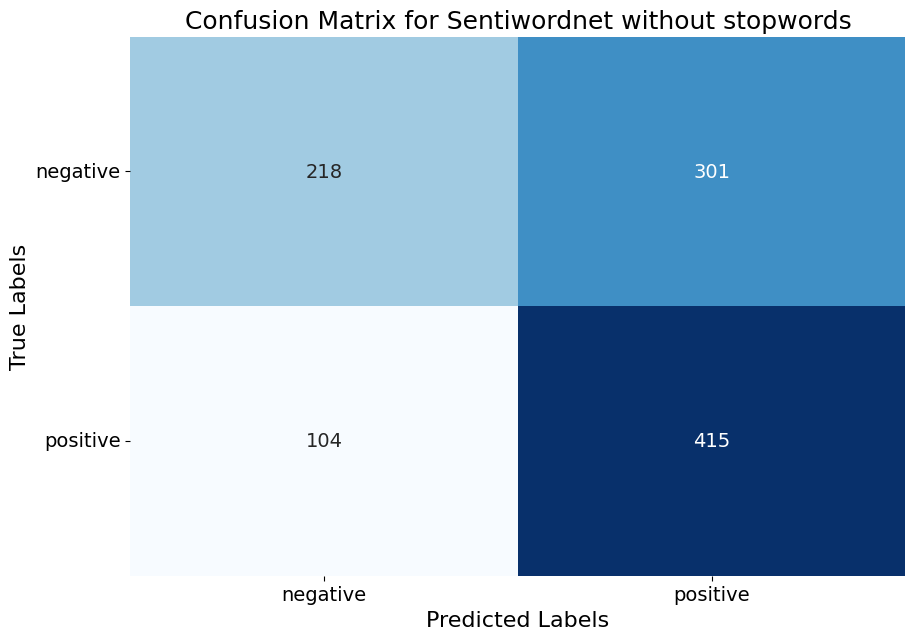

In [18]:
cm_nb = confusion_matrix(df_sentiwordnet_without_stopwords['Ground_Truth_Label'], df_sentiwordnet_without_stopwords['Sentiwordnet_Classification'])
plt.figure(figsize=(10, 7))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.xlabel('Predicted Labels', fontsize=16)
plt.ylabel('True Labels', fontsize=16)
plt.title('Confusion Matrix for Sentiwordnet without stopwords', fontsize=18)
plt.xticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14)
plt.yticks(ticks=[0.5, 1.5], labels=['negative', 'positive'], fontsize=14, rotation=0)
plt.show()